# HSI Classification: Local Similarity Analysis

This notebook demonstrates the hyperspectral image classification pipeline with focus on **Efficient local similarity**.

## Contents
1. Data Loading & Preprocessing
2. Patch Extraction
3. Similarity Metrics Exploration
4. Model Training with MLflow
5. Evaluation & Visualization

## 1. Setup & Imports

In [4]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import our modules
from src.data import load_hsi, load_benchmark_dataset, preprocess_pipeline
from src.features import extract_patches, split_dataset
from src.models import (
    rbf_similarity, sam_similarity, local_similarity_matrix,
    SVMClassifier, create_model, train_svm, train_neural_network,
    compute_all_metrics, print_classification_report
)

# MLflow
import mlflow
mlflow.set_tracking_uri('mlruns')

print("✓ All imports successful!")

✓ All imports successful!


## 2. Generate Synthetic Data (for testing)

Replace this with actual HSI data loading in practice.

In [7]:
# Generate synthetic hyperspectral cube for demonstration
np.random.seed(42)

# Dimensions
height, width, n_bands = 100, 100, 200
n_classes = 5

# Create class-specific spectral signatures
class_spectra = np.random.randn(n_classes, n_bands)

# Generate ground truth
ground_truth = np.zeros((height, width), dtype=np.int32)
for c in range(n_classes):
    mask = np.random.random((height, width)) < (1 / n_classes)
    ground_truth[mask] = c

# Generate HSI cube based on ground truth
hsi_cube = np.zeros((height, width, n_bands), dtype=np.float32)
for c in range(n_classes):
    mask = ground_truth == c
    hsi_cube[mask] = class_spectra[c] + 0.1 * np.random.randn(np.sum(mask), n_bands)

print(f"HSI Cube shape: {hsi_cube.shape}")
print(f"Ground Truth shape: {ground_truth.shape}")
print(f"Classes: {np.unique(ground_truth)}")

HSI Cube shape: (100, 100, 200)
Ground Truth shape: (100, 100)
Classes: [0 1 2 3 4]


## 3. Preprocessing

In [10]:
# Apply preprocessing pipeline
result = preprocess_pipeline(
    hsi_cube,
    remove_water=False,  # No water bands in synthetic data
    reduce_dims='pca',
    n_components=30,
    normalize='minmax',
    log_to_mlflow=False
)

processed_data = result['data']
print(f"Processed shape: {processed_data.shape}")

Processed shape: (100, 100, 30)


## 4. Patch Extraction

In [13]:
# Extract patches
window_size = 5
dataset = extract_patches(
    processed_data,
    ground_truth,
    window_size=window_size,
    include_background=False,
    log_to_mlflow=False
)

print(f"Patches shape: {dataset.patches.shape}")
print(f"Number of samples: {dataset.n_samples}")

# Split into train/val/test
train_set, val_set, test_set = split_dataset(
    dataset,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    stratify=True,
    log_to_mlflow=False
)

print(f"Train: {train_set.n_samples}, Val: {val_set.n_samples}, Test: {test_set.n_samples}")

Patches shape: (5930, 5, 5, 30)
Number of samples: 5930
Train: 3558, Val: 1186, Test: 1186


## 5. Local Similarity Analysis

This is the core of the thesis research.

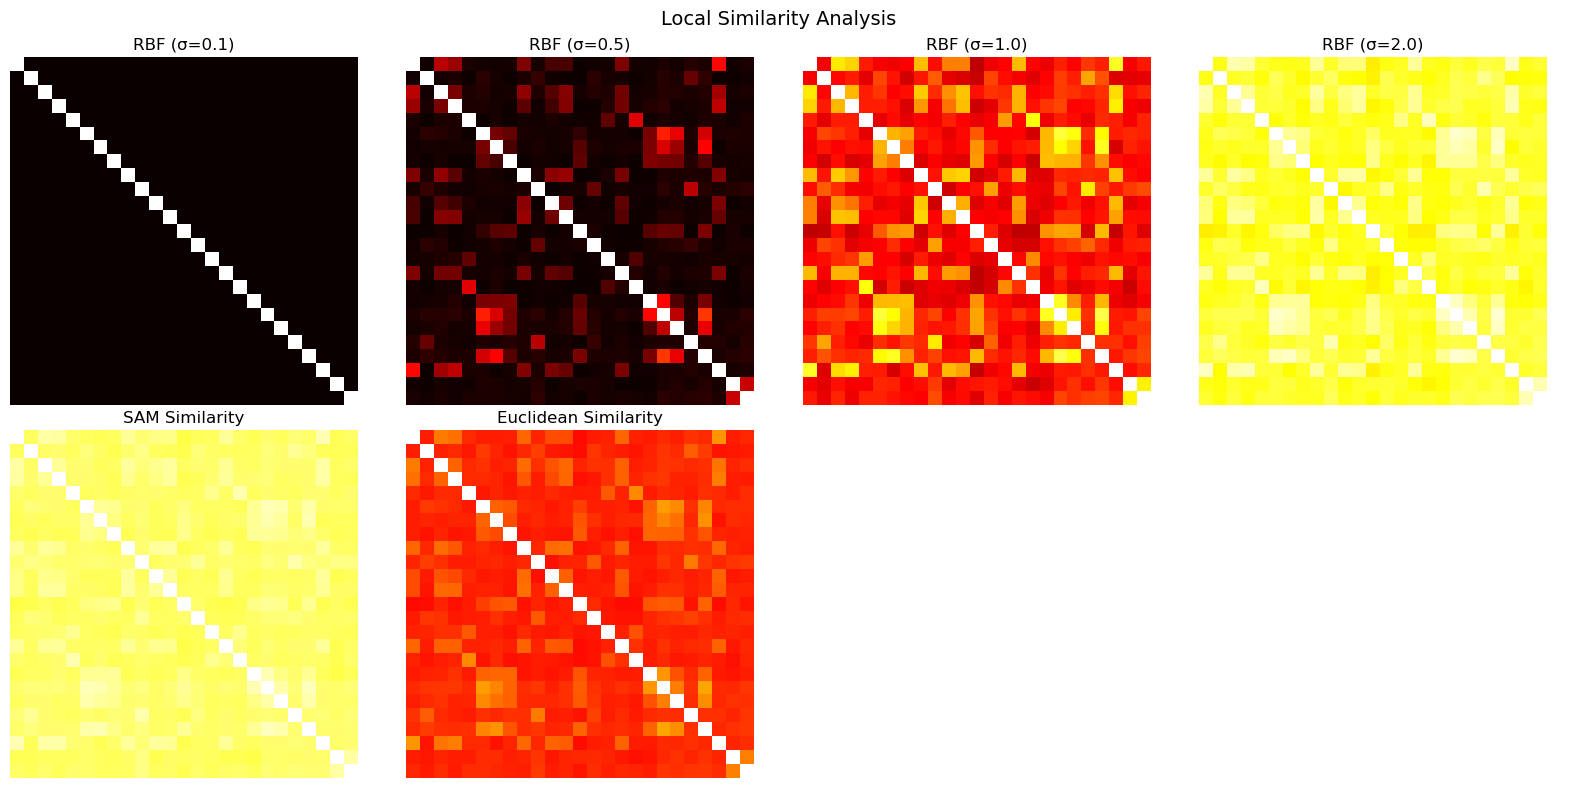

In [16]:
# Analyze local similarity for a sample patch
sample_patch = train_set.patches[0]

# Different similarity metrics
sigmas = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(2, len(sigmas), figsize=(16, 8))

# RBF similarity with different sigma values
for i, sigma in enumerate(sigmas):
    sim_matrix = local_similarity_matrix(sample_patch, metric='rbf', sigma=sigma)
    
    axes[0, i].imshow(sim_matrix, cmap='hot', vmin=0, vmax=1)
    axes[0, i].set_title(f'RBF (σ={sigma})')
    axes[0, i].axis('off')

# SAM vs Euclidean
sim_sam = local_similarity_matrix(sample_patch, metric='sam')
sim_euc = local_similarity_matrix(sample_patch, metric='euclidean')

axes[1, 0].imshow(sim_sam, cmap='hot', vmin=0, vmax=1)
axes[1, 0].set_title('SAM Similarity')
axes[1, 0].axis('off')

axes[1, 1].imshow(sim_euc, cmap='hot', vmin=0, vmax=1)
axes[1, 1].set_title('Euclidean Similarity')
axes[1, 1].axis('off')

# Hide unused axes
for j in range(2, len(sigmas)):
    axes[1, j].axis('off')

plt.suptitle('Local Similarity Analysis', fontsize=14)
plt.tight_layout()
plt.show()

## 6. SVM Classification

In [19]:
# Prepare flattened features for SVM
X_train = train_set.get_center_pixels()
y_train = train_set.labels

X_val = val_set.get_center_pixels()
y_val = val_set.labels

X_test = test_set.get_center_pixels()
y_test = test_set.labels

print(f"X_train shape: {X_train.shape}")

# Train SVM with RBF kernel (relates to RBF similarity in thesis)
svm = train_svm(
    X_train, y_train,
    X_val, y_val,
    kernel='rbf',
    C=10.0,
    gamma='scale',
    experiment_name='hsi_classification',
    run_name='SVM_RBF_baseline',
    log_to_mlflow=True
)

# Evaluate on test set
y_pred = svm.predict(X_test)
print_classification_report(y_test, y_pred)

/opt/anaconda3/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/02/05 12:38:31 INFO mlflow.tracking.fluent: Experiment with name 'hsi_classification' does not exist. Creating a new experiment.


X_train shape: (3558, 30)


2026/02/05 12:38:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


CLASSIFICATION REPORT
Overall Accuracy (OA):    1.0000
Average Accuracy (AA):    1.0000
Kappa Coefficient:        1.0000

------------------------------------------------------------
Per-Class Accuracy:
------------------------------------------------------------
  1                              1.0000
  2                              1.0000
  3                              1.0000
  4                              1.0000

------------------------------------------------------------
Per-Class Statistics:
------------------------------------------------------------
Class                           Precision     Recall   F1-Score    Support
1                                  1.0000     1.0000     1.0000        211
2                                  1.0000     1.0000     1.0000        251
3                                  1.0000     1.0000     1.0000        318
4                                  1.0000     1.0000     1.0000        406


'============================================================\nCLASSIFICATION REPORT\n============================================================\nOverall Accuracy (OA):    1.0000\nAverage Accuracy (AA):    1.0000\nKappa Coefficient:        1.0000\n\n------------------------------------------------------------\nPer-Class Accuracy:\n------------------------------------------------------------\n  1                              1.0000\n  2                              1.0000\n  3                              1.0000\n  4                              1.0000\n\n------------------------------------------------------------\nPer-Class Statistics:\n------------------------------------------------------------\nClass                           Precision     Recall   F1-Score    Support\n1                                  1.0000     1.0000     1.0000        211\n2                                  1.0000     1.0000     1.0000        251\n3                                  1.0000     1.0000     1.000

## 7. Neural Network Classification

In [22]:
import torch
from src.models import create_model, train_neural_network, create_data_loaders, TrainingConfig

# Get dimensions
n_bands = train_set.patches.shape[-1]
n_classes_nn = len(np.unique(train_set.labels))

# Create 3D-CNN model
model = create_model(
    model_type='3d_cnn',
    n_bands=n_bands,
    n_classes=n_classes_nn,
    patch_size=window_size
)
print(model)

# Create data loaders
train_loader = create_data_loaders(train_set.patches, train_set.labels, batch_size=32, data_format='3d')
val_loader = create_data_loaders(val_set.patches, val_set.labels, batch_size=32, shuffle=False, data_format='3d')

# Training config
config = TrainingConfig(
    experiment_name='hsi_classification',
    run_name='3D_CNN_experiment',
    n_epochs=20,
    batch_size=32,
    learning_rate=0.001,
    patience=10
)

# Train (set log_to_mlflow=True to track with MLflow)
model, history = train_neural_network(
    model, train_loader, val_loader,
    config=config,
    similarity_config={'metric': 'patch_based', 'window_size': window_size},
    log_to_mlflow=True
)

SpatialSpectralCNN3D(
  (features): Sequential(
    (0): Conv3d(1, 32, kernel_size=(7, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 64, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(64, 128, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
    (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (gap): AdaptiveAvgPool3d(output_size=1)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)


IndexError: Target 4 is out of bounds.

## 8. Visualization

NameError: name 'history' is not defined

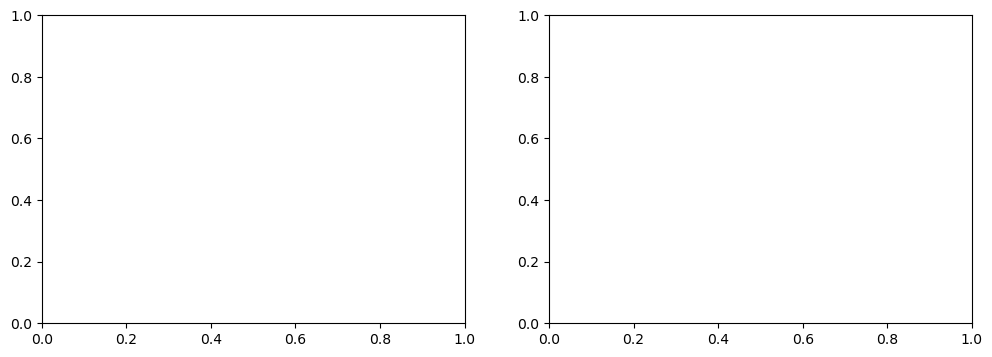

In [25]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()